In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from datetime import datetime
import os
from thermal_lib import *

%matplotlib tk

In [2]:

pth = r'D:\thermography\cdkl5_thermal_behaviour_group1\unico'
#pth = None
sub = Subjects(pth)
print(sub)

Number of Subjects: 8

0 -> ID: KO_69 RECs: 3
1 -> ID: WT_71 RECs: 3
2 -> ID: KO_70 RECs: 3
3 -> ID: WT_74 RECs: 3
4 -> ID: WT_79 RECs: 3
5 -> ID: KO_72 RECs: 3
6 -> ID: WT_81 RECs: 3
7 -> ID: KO_75 RECs: 3



In [3]:
sub.get_data_min(0)

,minute,day,hour,RT,isDay,temp_avg,temp_med,temp_max,centroid_x,centroid_y,temp_med_delta,distance,RT_delta,temp_rt_diff,temp_norm,RT_norm,temp_rt_corrected
0,0,1,0.0,23.849615,0.0,27.156424,27.156424,29.390870,64.840291,43.930024,0.284777,0.036347,0.334562,3.306808,0.381702,0.320190,0.061512
1,1,1,0.0,23.834576,0.0,27.091588,27.091588,29.168012,64.511230,43.228525,0.219942,0.039896,0.319522,3.257013,0.316866,0.305150,0.011716
2,2,1,0.0,23.831831,0.0,27.055950,27.055950,29.031910,64.606798,42.567428,0.184303,0.032529,0.316778,3.224118,0.281227,0.302405,-0.021178
3,3,1,0.0,23.828915,0.0,27.049409,27.049409,28.965370,64.474376,42.565394,0.177763,0.035054,0.313862,3.220494,0.274687,0.299489,-0.024802
4,4,1,0.0,23.821290,0.0,27.072068,27.072068,29.089194,64.438620,42.667422,0.200422,0.037453,0.306237,3.250778,0.297346,0.291864,0.005482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,1435,7,23.0,23.960309,0.0,27.024068,27.024068,28.967704,44.793738,50.330130,-0.026311,0.044383,0.060909,3.063760,0.249346,0.430883,-0.181537
10076,1436,7,23.0,23.945741,0.0,27.094582,27.094582,29.275783,43.918062,50.076026,0.044203,0.079831,0.046341,3.148841,0.319860,0.416315,-0.096455
10077,1437,7,23.0,23.945128,0.0,27.013853,27.013853,29.021485,42.660631,50.120480,-0.036527,0.026375,0.045728,3.068725,0.239130,0.415702,-0.176571
10078,1438,7,23.0,23.921871,0.0,26.979497,26.979497,28.928854,42.473763,50.105911,-0.070883,0.022832,0.022471,3.057626,0.204774,0.392445,-0.187671


In [8]:
tc = sub.get_data_min(0)
dis = tc['distance']
isd = tc['isDay']

fig,ax = plt.subplots()
ax.axhline(0,color='k',linestyle='--')
ax.plot(dis-dis[isd>0].median())
#ax.axhline(dis[isd>0].median(),color='r')
ax.fill_between(dis.index,y1=0,y2=5,where=isd==0,color='gray',alpha=.3)
plt.show()

In [3]:



def plot_avg(var, isDay, draw_sub=True, draw_sem = True, draw_zero = False, ax=None, color='b'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    if draw_zero:
        ax.axhline(0,color='k',linestyle='--')

    if draw_sub:
        for c in var.columns:
            ax.plot(var.index, var[c],color,alpha=.1)

    avg = var.mean(axis=1) 

    if draw_sem:
        sem = var.sem(axis=1) 
        ax.fill_between(var.index, avg+sem, avg-sem, alpha=.3, color=color,edgecolor='none')

    ax.plot(var.index, avg,color,alpha=1)
    xlims = [var.index[0], var.index[-1]]
    ax.set_xlim(xlims)
    ylims = ax.get_ylim()
    ax.fill_between(var.index, y1=ylims[0], y2=ylims[1], where=isDay<1,alpha=.2, color='gray',edgecolor='none')
    ax.set_ylim(ylims)
    #ax.set_xlabel('Time [Hours]')




## 24 Hours average

<IPython.core.display.Javascript object>


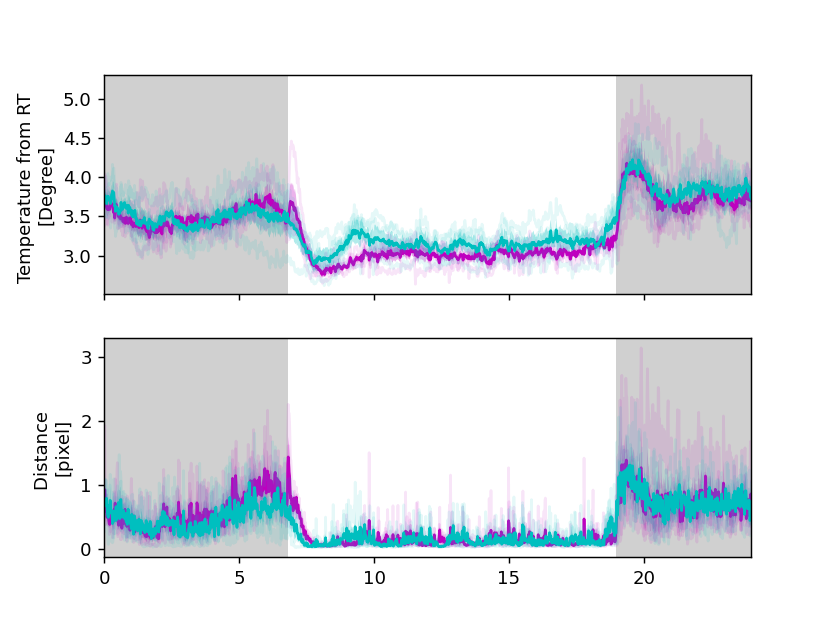

Text(0, 0.5, 'Distance \n[pixel]')

In [4]:


# motion 
motion = dict()
isDay = list()
for info,rec in sub.iter_data_day():
    motion[(info['geno'], info['id'])] = rec['distance']
isDay = rec.isDay
motion = pd.DataFrame.from_dict(motion)
motion.index = motion.index/60

# temperature 
temperature = dict()
isDay = list()
for info,rec in sub.iter_data_day():
    temperature[(info['geno'], info['id'])] = rec['temp_rt_diff']
isDay = rec.isDay

temperature = pd.DataFrame.from_dict(temperature,)
temperature.index = temperature.index/60

fig,ax = plt.subplots(2,1,sharex=True) 
plot_avg(temperature.xs('KO',level=0,axis=1), isDay,color='m',ax=ax[0])
plot_avg(temperature.xs('WT',level=0,axis=1), isDay,color='c',ax=ax[0])
ax[0].set_ylabel('Temperature from RT \n[Degree]')

plot_avg(motion.xs('KO',level=0,axis=1), isDay,color='m', ax=ax[1])
plot_avg(motion.xs('WT',level=0,axis=1), isDay,color='c', ax=ax[1])
ax[1].set_ylabel('Distance \n[pixel]')

<IPython.core.display.Javascript object>


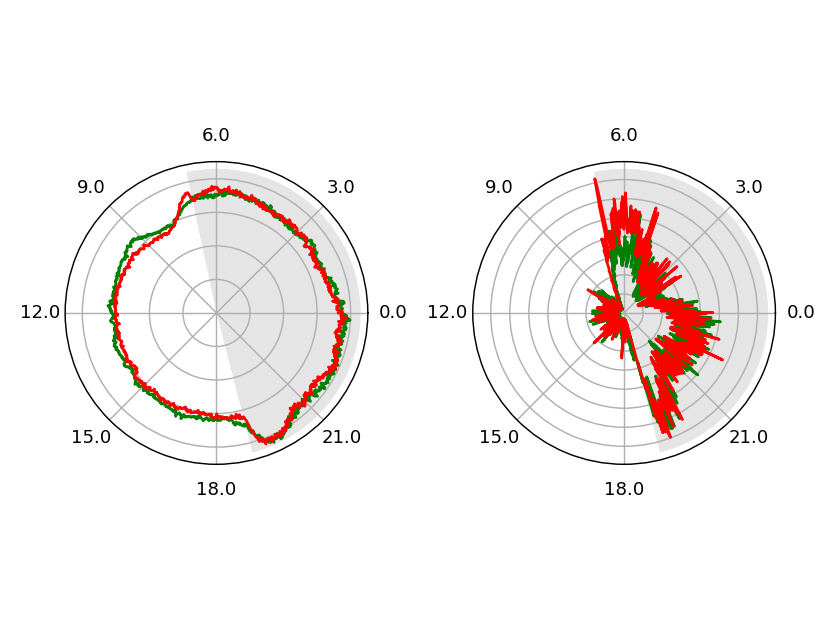

In [5]:

import numpy as np
from matplotlib import pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(122,polar=True)

theta = (motion.index/motion.index[-1])*2*np.pi
ax.plot(theta, motion.xs('WT',level=0,axis=1).mean(axis=1).values,color='g' )
ax.plot(theta, motion.xs('KO',level=0,axis=1).mean(axis=1).values,color='r' )
ylims = ax.get_ylim()
ax.fill_between(theta, y1=ylims[0], y2=ylims[1], where=isDay<1,alpha=.2, color='gray',edgecolor='none')
ax.set_yticklabels([])
tmp = np.array([(c, radians2hour(c) ) for c in ax.get_xticks()])
ax.set_xticks(tmp[:,0],tmp[:,1])

ax = fig.add_subplot(121,polar=True)

ax.plot(theta, temperature.xs('WT',level=0,axis=1).mean(axis=1).values,color='g' )
ax.plot(theta, temperature.xs('KO',level=0,axis=1).mean(axis=1).values,color='r' )
ylims = ax.get_ylim()
ax.set_yticklabels([])
ax.fill_between(theta, y1=ylims[0], y2=ylims[1], where=isDay<1,alpha=.2, color='gray',edgecolor='none')

tmp = np.array([(c, radians2hour(c) ) for c in ax.get_xticks()])
ax.set_xticks(tmp[:,0],tmp[:,1])

plt.tight_layout()

<IPython.core.display.Javascript object>


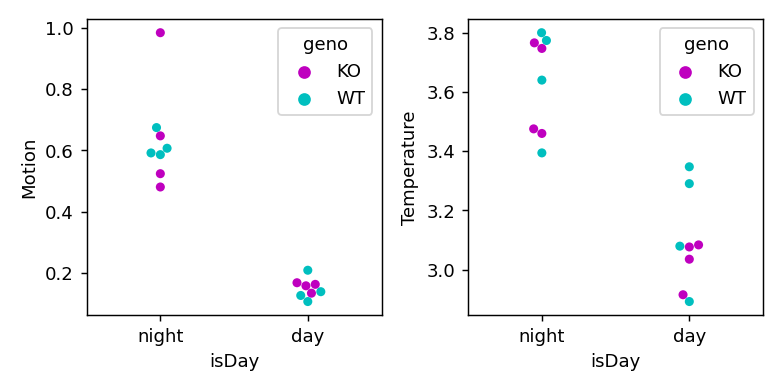

In [6]:
import seaborn as sns

motion_night = motion.loc[isDay.values==0,:].mean().reset_index().rename( columns={'level_0':'geno', 'level_1':'sub'})
motion_day = motion.loc[isDay.values==1,:].mean().reset_index().rename( columns={'level_0':'geno', 'level_1':'sub'})
motion_night['isDay'] = 'night'
motion_day['isDay'] = 'day'
motion_day_night = pd.concat([motion_night,motion_day])

temperature_night = temperature.loc[isDay.values==0,:].mean().reset_index().rename( columns={'level_0':'geno', 'level_1':'sub'})
temperature_day = temperature.loc[isDay.values==1,:].mean().reset_index().rename( columns={'level_0':'geno', 'level_1':'sub'})
temperature_night['isDay'] = 'night'
temperature_day['isDay'] = 'day'
temperature_day_night = pd.concat([temperature_night,temperature_day])


fig,ax = plt.subplots(1,2,figsize=(6,3))
sns.swarmplot(data=motion_day_night, x='isDay', y=0, hue='geno', ax=ax[0], palette=['m','c'])
ax[0].set_ylabel('Motion')

sns.swarmplot(data=temperature_day_night, x='isDay', y=0, hue='geno', ax=ax[1], palette=['m','c'])
ax[1].set_ylabel('Temperature')

plt.tight_layout()

<IPython.core.display.Javascript object>


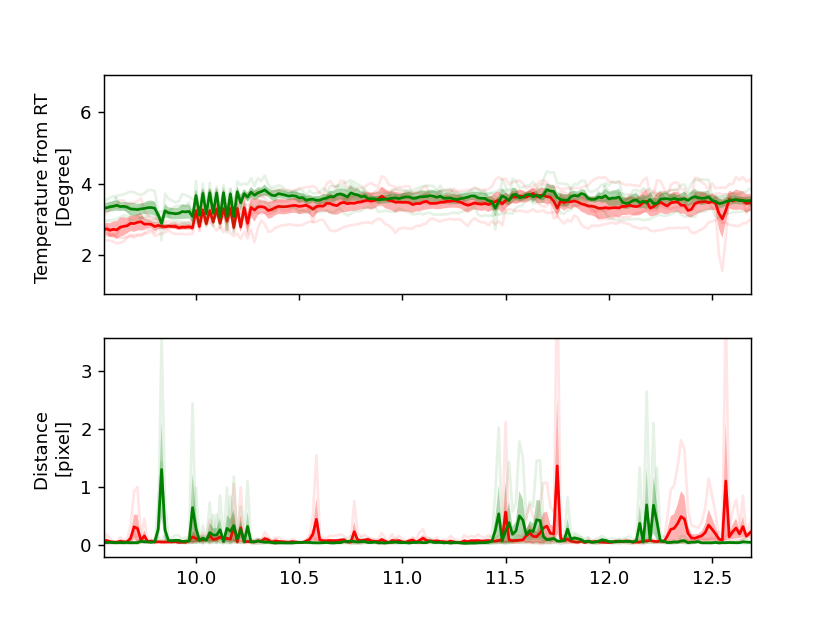

Text(0, 0.5, 'Distance \n[pixel]')

In [7]:


# motion 
motion_minutes = dict()
for info,rec in sub.iter_data_min():
    motion_minutes[(info['geno'], info['id'])] = rec['distance']
isDay = rec.isDay
motion_minutes = pd.DataFrame.from_dict(motion_minutes,)
motion_minutes.index = motion_minutes.index/60

# temperature 
temperature_minutes = dict()
for info,rec in sub.iter_data_min():
    temperature_minutes[(info['geno'], info['id'])] = rec['temp_rt_diff']
isDay = rec.isDay
temperature_minutes = pd.DataFrame.from_dict(temperature_minutes,)
temperature_minutes.index = temperature_minutes.index/60

fig,ax = plt.subplots(2,1,sharex=True) 
plot_avg(temperature_minutes.xs('KO',level=0,axis=1), isDay,color='r',ax=ax[0])
plot_avg(temperature_minutes.xs('WT',level=0,axis=1), isDay,color='g',ax=ax[0])
ax[0].set_ylabel('Temperature from RT \n[Degree]')

plot_avg(motion_minutes.xs('KO',level=0,axis=1), isDay,color='r', ax=ax[1])
plot_avg(motion_minutes.xs('WT',level=0,axis=1), isDay,color='g', ax=ax[1])
ax[1].set_ylabel('Distance \n[pixel]')

<IPython.core.display.Javascript object>


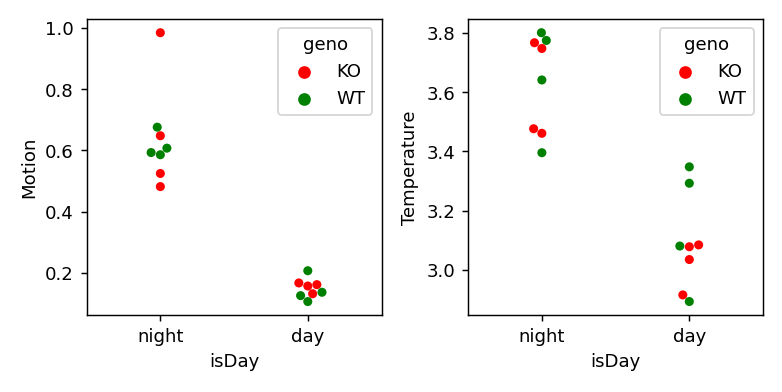

In [8]:
motion_minutes_night = motion_minutes.loc[isDay.values==0,:].mean().reset_index().rename( columns={'level_0':'geno', 'level_1':'sub'})
motion_minutes_day = motion_minutes.loc[isDay.values==1,:].mean().reset_index().rename( columns={'level_0':'geno', 'level_1':'sub'})
motion_minutes_night['isDay'] = 'night'
motion_minutes_day['isDay'] = 'day'
motion_minutes_day_night = pd.concat([motion_minutes_night,motion_minutes_day])

temperature_minutes_night = temperature_minutes.loc[isDay.values==0,:].mean().reset_index().rename( columns={'level_0':'geno', 'level_1':'sub'})
temperature_minutes_day = temperature_minutes.loc[isDay.values==1,:].mean().reset_index().rename( columns={'level_0':'geno', 'level_1':'sub'})
temperature_minutes_night['isDay'] = 'night'
temperature_minutes_day['isDay'] = 'day'
temperature_minutes_day_night = pd.concat([temperature_minutes_night,temperature_minutes_day])


fig,ax = plt.subplots(1,2,figsize=(6,3))
sns.swarmplot(data=motion_minutes_day_night, x='isDay', y=0, hue='geno', ax=ax[0], palette=['r','g'])
ax[0].set_ylabel('Motion')

sns.swarmplot(data=temperature_minutes_day_night, x='isDay', y=0, hue='geno', ax=ax[1], palette=['r','g'])
ax[1].set_ylabel('Temperature')

plt.tight_layout()

# Spectral Density

<IPython.core.display.Javascript object>


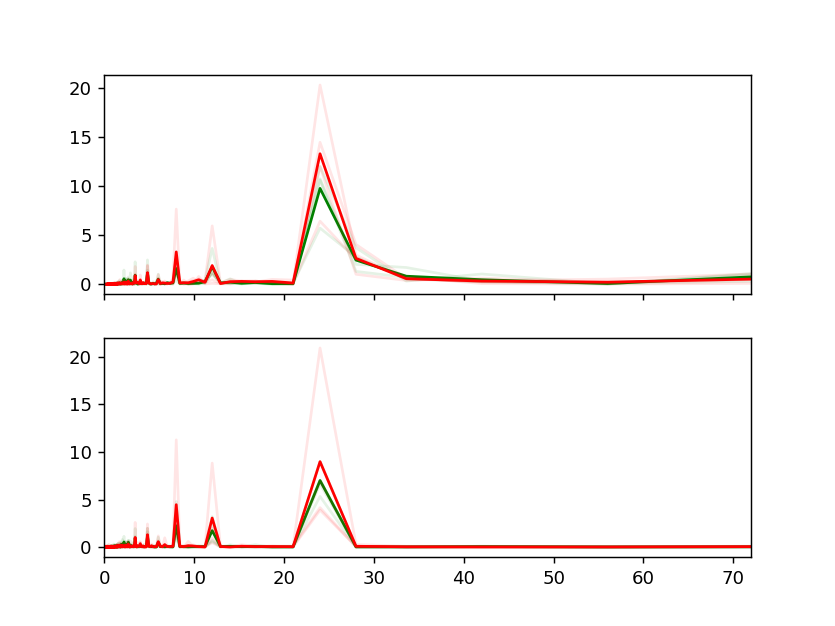

In [9]:
fig,ax = plt.subplots(2,1,sharex=True)

wt_temperature = temperature_minutes.xs('WT',level=0,axis=1).fillna(0)
wt_temperature_psd = dict()
wt_temperature_params = list()
wt_temperature_curve = dict()
for c in wt_temperature.columns:
    cosinor = Cosinor(wt_temperature[c].values)
    wt_temperature_psd[c] = cosinor.power_spectrum
    cosinor.compontents['sub'] = c
    cosinor.compontents['geno'] = 'WT'
    wt_temperature_params.append( cosinor.compontents )
    wt_temperature_curve[c] = cosinor.curve
    ax[0].plot(cosinor.period ,cosinor.power_spectrum,color='g', alpha = .1)
wt_temperature_psd = pd.DataFrame.from_dict(wt_temperature_psd)
wt_temperature_psd.index = cosinor.period 
ax[0].plot(wt_temperature_psd.index , wt_temperature_psd.mean(axis=1), color='g', alpha = 1)

ko_temperature = temperature_minutes.xs('KO',level=0,axis=1).fillna(0)
ko_temperature_psd = dict()
ko_temperature_params = list()
ko_temperature_curve = dict()
for c in ko_temperature.columns:
    cosinor = Cosinor(ko_temperature[c].values)
    ko_temperature_psd[c] = cosinor.power_spectrum
    cosinor.compontents['sub'] = c
    cosinor.compontents['geno'] = 'KO'
    ko_temperature_curve[c] = cosinor.curve
    ko_temperature_params.append( cosinor.compontents )
    ax[0].plot(cosinor.period , cosinor.power_spectrum, color='r', alpha = .1)
ko_temperature_psd = pd.DataFrame.from_dict(ko_temperature_psd)
ko_temperature_psd.index = cosinor.period 
ax[0].plot(ko_temperature_psd.index , ko_temperature_psd.mean(axis=1), color='r', alpha = 1)

temperature_params = pd.concat([pd.concat(wt_temperature_params), pd.concat(ko_temperature_params)])
temperature_params['acrophase_rad'] = temperature_params['acrophase'].apply(hour2radians)
temperature_params['acrophase_rad_rng'] = temperature_params['acrophase_rad'].apply(wrap2pi)

wt_motion = motion_minutes.xs('WT',level=0,axis=1).fillna(0)
wt_motion_psd = dict()
wt_motion_params = list()
wt_motion_curve = dict()
for c in wt_motion.columns:
    cosinor = Cosinor(wt_motion[c].values)
    wt_motion_psd[c] = cosinor.power_spectrum
    cosinor.compontents['sub'] = c
    cosinor.compontents['geno'] = 'WT'
    wt_motion_curve[c] = cosinor.curve
    wt_motion_params.append( cosinor.compontents )
    ax[1].plot(cosinor.period ,cosinor.power_spectrum,color='g', alpha = .1)
wt_motion_psd = pd.DataFrame.from_dict(wt_motion_psd)
wt_motion_psd.index = cosinor.period 
ax[1].plot(wt_motion_psd.index , wt_motion_psd.mean(axis=1), color='g', alpha = 1)

wt_temperature_curve = pd.DataFrame.from_dict(wt_temperature_curve)
ko_temperature_curve = pd.DataFrame.from_dict(ko_temperature_curve)

ko_motion = motion_minutes.xs('KO',level=0,axis=1).fillna(0)
ko_motion_psd = dict()
ko_motion_params = list()
ko_motion_curve = dict()
for c in ko_motion.columns:
    cosinor = Cosinor(ko_motion[c].values)
    ko_motion_psd[c] = cosinor.power_spectrum
    cosinor.compontents['sub'] = c
    cosinor.compontents['geno'] = 'KO'
    ko_motion_curve[c] = cosinor.curve
    ko_motion_params.append( cosinor.compontents )
    ax[1].plot(cosinor.period , cosinor.power_spectrum, color='r', alpha = .1)
ko_motion_psd = pd.DataFrame.from_dict(ko_motion_psd)
ko_motion_psd.index = cosinor.period 
ax[1].plot(ko_motion_psd.index , ko_motion_psd.mean(axis=1), color='r', alpha = 1)
ax[1].set_xlim([0,72])

motion_params = pd.concat([pd.concat(wt_motion_params), pd.concat(ko_motion_params)])
motion_params['acrophase_rad'] = motion_params['acrophase'].apply(hour2radians)
motion_params['acrophase_rad_rng'] = motion_params['acrophase_rad'].apply(wrap2pi)


<IPython.core.display.Javascript object>


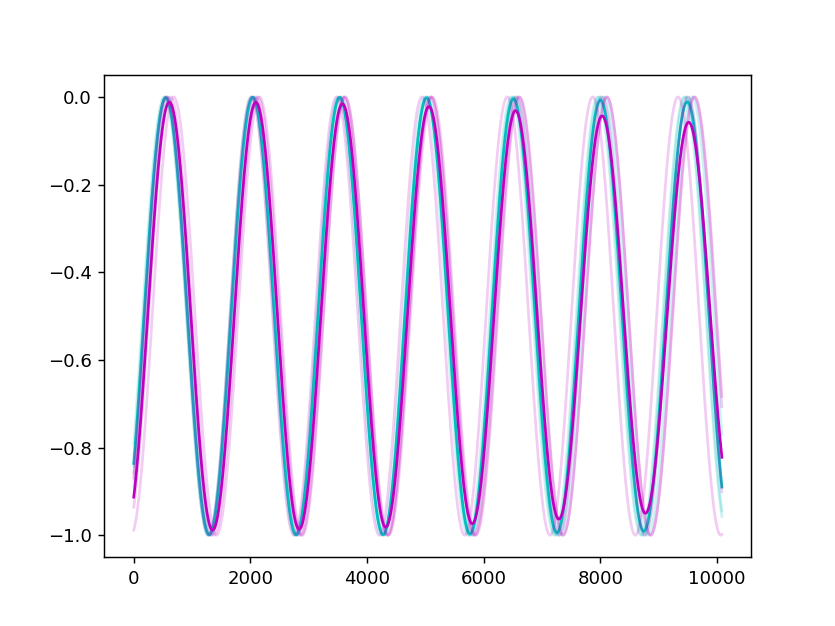

In [11]:
fig, ax = plt.subplots()

wt_temperature_curve_dem = (wt_temperature_curve-wt_temperature_curve.min(axis=0))/(wt_temperature_curve.min(axis=0)-wt_temperature_curve.max(axis=0))
ko_temperature_curve_dem = (ko_temperature_curve-ko_temperature_curve.min(axis=0))/(ko_temperature_curve.min(axis=0)-ko_temperature_curve.max(axis=0))
for c in wt_temperature_curve_dem.columns:
    ax.plot(wt_temperature_curve_dem[c],'c',alpha=0.2)
ax.plot(wt_temperature_curve_dem.mean(axis=1),'c',alpha=1)
for c in ko_temperature_curve_dem.columns:
    ax.plot(ko_temperature_curve_dem[c],'m',alpha=0.2)
ax.plot(ko_temperature_curve_dem.mean(axis=1),'m',alpha=1)
 

<IPython.core.display.Javascript object>


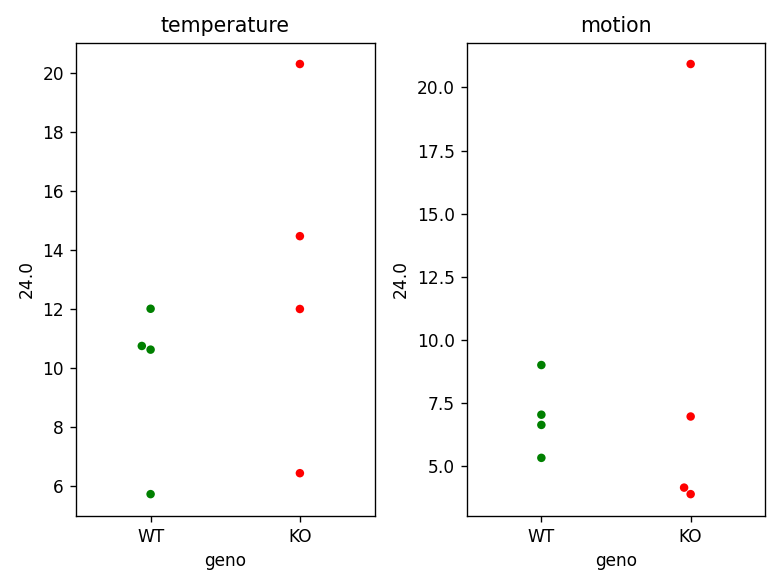

In [17]:
wt_temperature_psd_24 = pd.concat([wt_temperature_psd.loc[23.5:25.5].T,ko_temperature_psd.loc[23.5:25.5].T])
wt_motion_psd_24 = pd.concat([wt_motion_psd.loc[23.5:25.5].T,ko_motion_psd.loc[23.5:25.5].T])
wt_temperature_psd_24.columns = np.round(wt_temperature_psd_24.columns,0)
wt_motion_psd_24.columns = np.round(wt_motion_psd_24.columns,0)
wt_temperature_psd_24['geno'] = [i.split('_')[0] for i in wt_temperature_psd_24.index]
wt_motion_psd_24['geno'] = [i.split('_')[0] for i in wt_motion_psd_24.index]

fig, ax = plt.subplots(1,2)
sns.swarmplot(data=wt_temperature_psd_24,x='geno',y=24,ax=ax[0],palette=['g','r'])
ax[0].set_title('temperature')
sns.swarmplot(data=wt_motion_psd_24,x='geno',y=24,ax=ax[1],palette=['g','r'])
ax[1].set_title('motion')


plt.tight_layout()


<IPython.core.display.Javascript object>


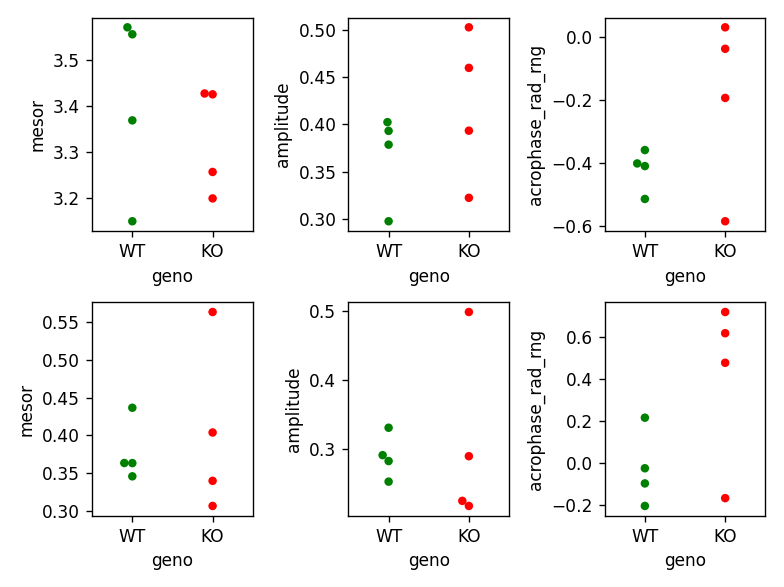

In [18]:
fig,ax = plt.subplots(2,3)

sns.swarmplot(data=temperature_params,x='geno',y='mesor',ax=ax[0,0], palette=['g','r'])
sns.swarmplot(data=temperature_params,x='geno',y='amplitude',ax=ax[0,1], palette=['g','r'])
sns.swarmplot(data=temperature_params,x='geno',y='acrophase_rad_rng',ax=ax[0,2], palette=['g','r'])

sns.swarmplot(data=motion_params,x='geno',y='mesor',ax=ax[1,0], palette=['g','r'])
sns.swarmplot(data=motion_params,x='geno',y='amplitude',ax=ax[1,1], palette=['g','r'])
sns.swarmplot(data=motion_params,x='geno',y='acrophase_rad_rng',ax=ax[1,2], palette=['g','r'])


plt.tight_layout()

In [19]:
motion_params

,mesor,amplitude,period,acrophase,sub,geno,acrophase_rad,acrophase_rad_rng
0,0.345526,0.330275,24.196411,23.228,WT_74,WT,6.081076,-0.202109
0,0.363192,0.251753,23.938133,0.830,WT_79,WT,0.217293,0.217293
0,0.363073,0.290316,24.094583,23.912,WT_71,WT,6.260147,-0.023038
0,0.436509,0.281714,23.787756,23.637,WT_81,WT,6.188152,-0.095033
0,0.339552,0.223721,23.756225,2.364,KO_70,KO,0.618894,0.618894
0,0.403673,0.288794,23.837574,2.749,KO_72,KO,0.719687,0.719687
0,0.306237,0.216326,24.145504,1.827,KO_69,KO,0.478307,0.478307
0,0.563559,0.498885,23.898766,23.370,KO_75,KO,6.118252,-0.164934


<IPython.core.display.Javascript object>


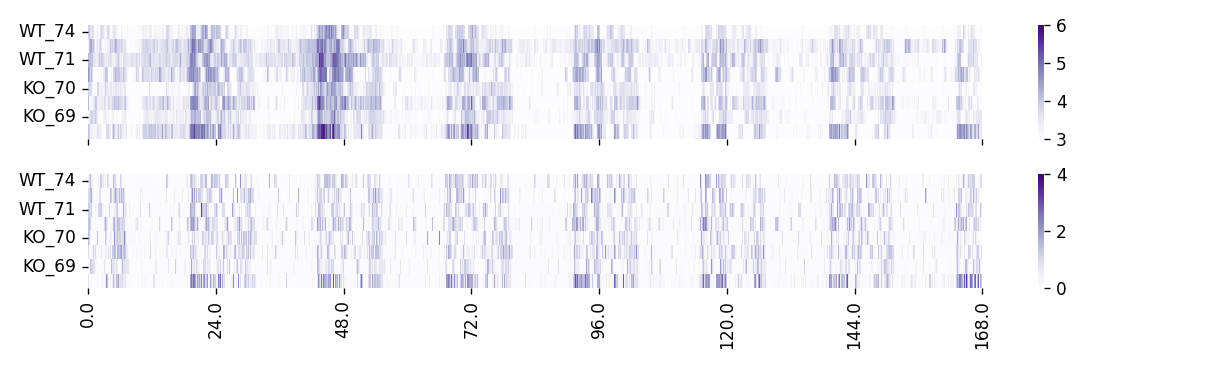

In [20]:
import seaborn as sns
fig,ax = plt.subplots(2,1,figsize=(10,3),sharex=True)
sns.heatmap(pd.concat([wt_temperature, ko_temperature],axis=1).rolling(5,center=True,min_periods=0).mean().T,cmap='Purples',ax=ax[0], vmin=3,vmax=6)
sns.heatmap(pd.concat([wt_motion, ko_motion],axis=1).rolling(5,center=True,min_periods=0).mean().T,cmap='Purples',ax=ax[1], vmin=0,vmax=4)
ax[1].set_xticks(range(0,len(wt_motion),1440) ,wt_motion.index[range(0,len(wt_motion),1440)])

plt.tight_layout()


<IPython.core.display.Javascript object>


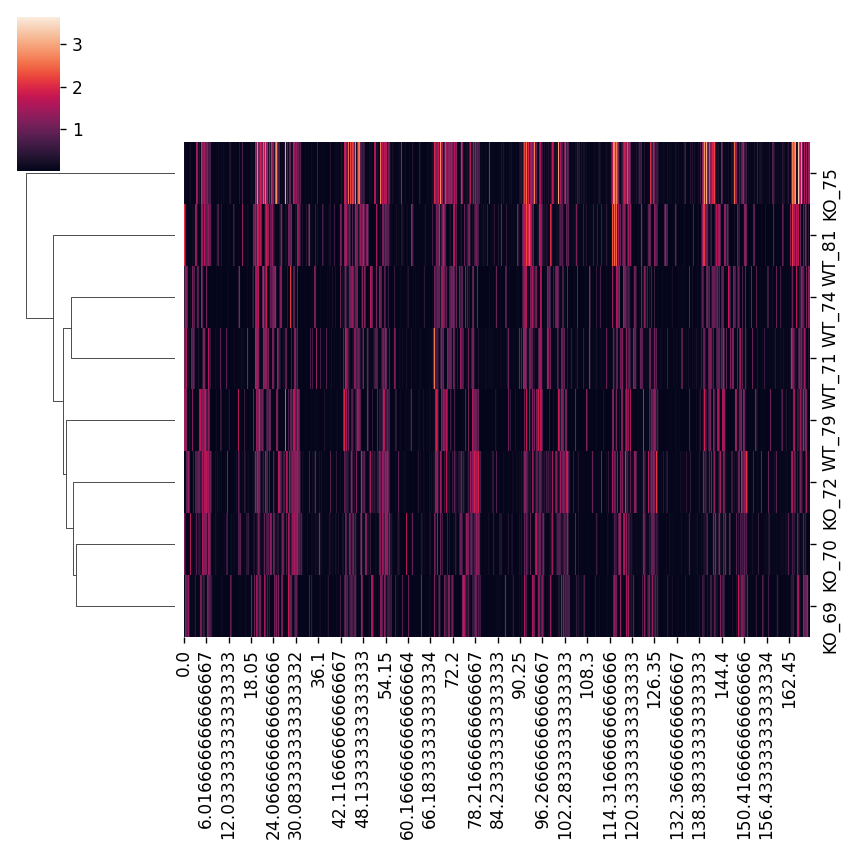

/home/oldboy/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [21]:

que = pd.concat([wt_motion, ko_motion],axis=1).rolling(5,center=True,min_periods=0).mean().T

sns.clustermap(que, figsize=(7,7),col_cluster=False,)

<IPython.core.display.Javascript object>


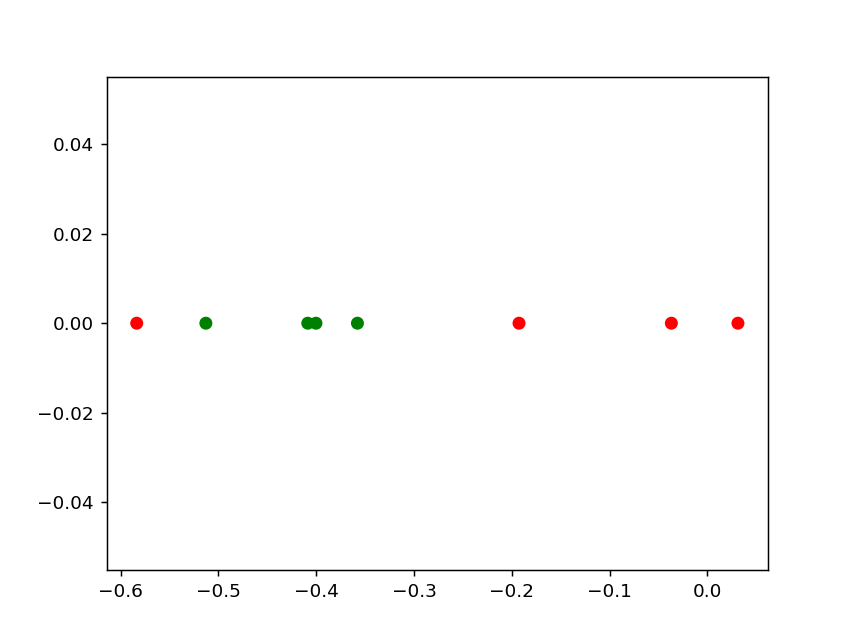

In [120]:
import math





fig,ax = plt.subplots()
colors = ['g' if geno=='WT' else 'r' for geno in temperature_params['geno']]
ax.scatter(temperature_params['acrophase_rad_rng'].values,temperature_params['acrophase_rad_rng'].index,c=colors)


<IPython.core.display.Javascript object>


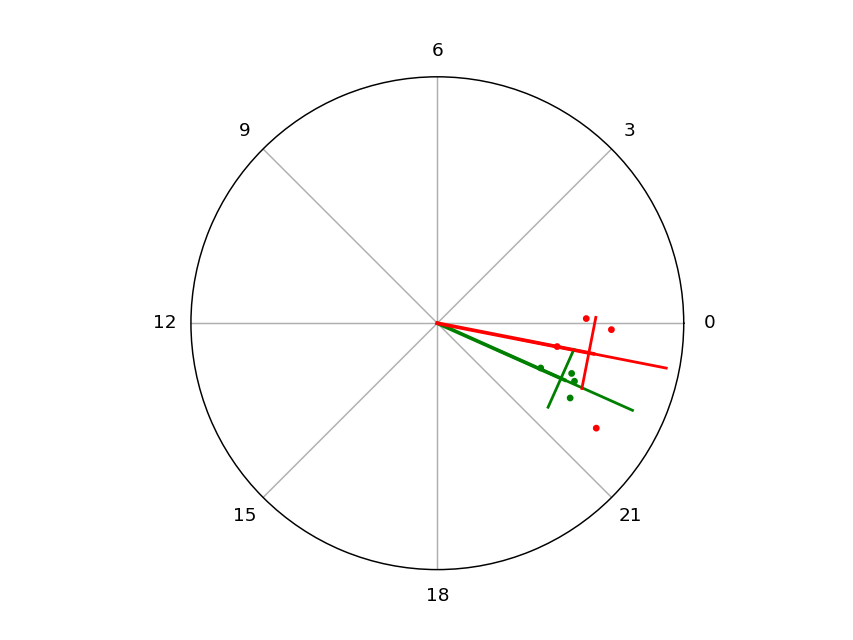

/tmp/ipykernel_7773/3586238983.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,3,6,9,12,15,18,21])


[]

In [125]:
import pycircstat as cs
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
colors = ['g' if c=='WT' else 'r' for c in temperature_params['geno']]
ax.scatter(temperature_params['acrophase_rad'] , temperature_params['amplitude'] ,
               c=colors, s=7, alpha=1)

wt_avg_theta = cs.mean(temperature_params['acrophase_rad'][temperature_params['geno']=='WT'])
wt_std_theta = cs.std(temperature_params['acrophase_rad'][temperature_params['geno']=='WT'])
wt_avg_amp = temperature_params['amplitude'][temperature_params['geno']=='WT'].mean()

ko_avg_theta = cs.mean(temperature_params['acrophase_rad'][temperature_params['geno']=='KO'])
ko_std_theta = cs.std(temperature_params['acrophase_rad'][temperature_params['geno']=='KO'])
ko_avg_amp = temperature_params['amplitude'][temperature_params['geno']=='KO'].mean()

ax.plot([wt_avg_theta, wt_avg_theta], [0, wt_avg_amp], 'g-', linewidth=2)
ax.plot([ko_avg_theta, ko_avg_theta], [0, ko_avg_amp], 'r-', linewidth=2)

ax.errorbar(wt_avg_theta, wt_avg_amp, xerr=ko_std_theta, yerr=.2, capsize=0, fmt="", c="g")
ax.errorbar(ko_avg_theta, ko_avg_amp, xerr=ko_std_theta, yerr=.2, capsize=0, fmt="", c="r")

ax.set_xticklabels([0,3,6,9,12,15,18,21])
ax.set_rticks([])
